# NFT GAN

What do the most expensive, most sought-after NFTs have in common? Truth is, we don't know. But using the power of GANs we might be able to find out.

In [1]:
import torch as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as Transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from ai import *
from networks import MyGAN
from tqdm import tqdm
from torchvision.utils import save_image
import copy
import joblib
import os
import imageio
import glob

### Image Hyper Parameters

In [2]:
image_size = 512
gen_image_size = 512
batch_size = 48
latent_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

### Load Dataset

In [3]:
train_ds = ImageFolder("new_dataset/", transform=Transforms.Compose([
    Transforms.Resize(image_size),
    Transforms.CenterCrop(image_size),
    Transforms.ToTensor(),
    Transforms.Normalize(*stats),
    AddGaussianNoise(0, 0.2)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [4]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


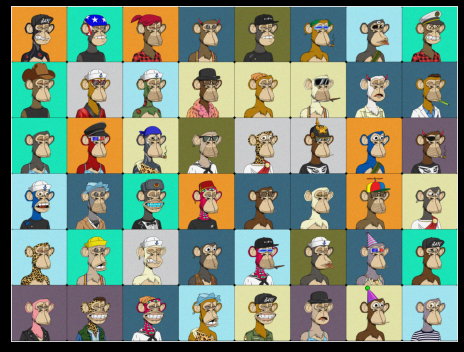

In [5]:
show_batch(train_dl)

torch.Size([48, 3, 512, 512])


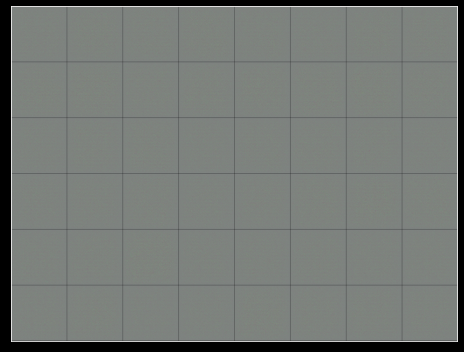

In [6]:
gan_model = MyGAN(latent_size, image_size, gen_image_size, batch_size, 0.9)

xb = T.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = gan_model.generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [7]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [8]:
def save_samples(index, latent_tensors, show=True):
    fake_images = gan_model.generator(latent_tensors)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("Saving", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Load stuff into the device

In [9]:
device = get_default_device()
gan_model.to_device(device)
train_dl = DeviceDataLoader(train_dl, device)

In [10]:
epochs = 500
lr_g = 0.0001
lr_d = 0.0003
start_idx = 1
disc_iter = 5

In [11]:
fixed_latent = T.randn(64, latent_size, 1, 1, device=gan_model.device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


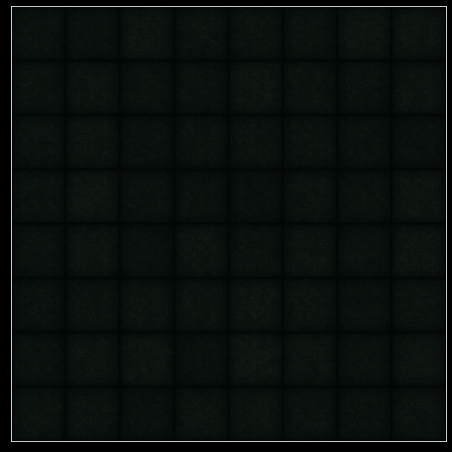

In [12]:
save_samples(0, fixed_latent)

### Train GAN

In [13]:
T.cuda.empty_cache()

print(f"Discriminator parameters count: {count_parameters(gan_model.discriminator)}")
print(f"Generator parameters count: {count_parameters(gan_model.generator)}")

# Losses & scores
losses_g = []
losses_d = []
real_scores = []
fake_scores = []

# Create optimizers
opt_d = T.optim.Adam(gan_model.discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
opt_g = T.optim.Adam(gan_model.generator.parameters(), lr=lr_g, betas=(0.5, 0.999))

#opt_d = T.optim.RMSprop(gan_model.discriminator.parameters(), lr=lr_d)
#opt_g = T.optim.RMSprop(gan_model.generator.parameters(), lr=lr_g)

for epoch in range(epochs):

    count = 0
    g_count = 0

    losses_d_int = []
    losses_g_int = []
    real_score_int = []
    fake_score_int = []
    
    for real_images, _ in tqdm(train_dl):
        # Train discriminator
        loss_d, real_score, fake_score = gan_model.train_discriminator(real_images, opt_d)
        # Train generator

        if count % disc_iter == 0:
            loss_g = gan_model.train_generator(opt_g)

            losses_g_int.append(loss_g)

            g_count += 1

        losses_d_int.append(loss_d)
        real_score_int.append(real_score)
        fake_score_int.append(fake_score)

        count += 1
        
    # Record losses & scores
    losses_g.append(sum(losses_g_int)/g_count)
    losses_d.append(sum(losses_d_int)/count)
    real_scores.append(sum(real_score_int)/count)
    fake_scores.append(sum(fake_score_int)/count)
    
    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

history = losses_g, losses_d, real_scores, fake_scores

Discriminator parameters count: 11203296
Generator parameters count: 13284064


100%|██████████| 209/209 [01:26<00:00,  2.42it/s]


Epoch [1/500], loss_g: -0.5132, loss_d: -0.0877, real_score: 0.4999, fake_score: 0.5134
Saving generated-images-0001.png


100%|██████████| 209/209 [01:25<00:00,  2.43it/s]


Epoch [2/500], loss_g: -0.5195, loss_d: 0.0117, real_score: 0.5000, fake_score: 0.5195
Saving generated-images-0002.png


100%|██████████| 209/209 [01:27<00:00,  2.38it/s]


Epoch [3/500], loss_g: -0.5236, loss_d: -0.0177, real_score: 0.4999, fake_score: 0.5237
Saving generated-images-0003.png


100%|██████████| 209/209 [01:29<00:00,  2.34it/s]


Epoch [4/500], loss_g: -0.5275, loss_d: -0.1578, real_score: 0.4999, fake_score: 0.5275
Saving generated-images-0004.png


100%|██████████| 209/209 [01:34<00:00,  2.21it/s]


Epoch [5/500], loss_g: -0.5307, loss_d: -0.0757, real_score: 0.4999, fake_score: 0.5308
Saving generated-images-0005.png


100%|██████████| 209/209 [01:30<00:00,  2.32it/s]


Epoch [6/500], loss_g: -0.5336, loss_d: -0.0360, real_score: 0.4999, fake_score: 0.5337
Saving generated-images-0006.png


100%|██████████| 209/209 [01:30<00:00,  2.31it/s]


Epoch [7/500], loss_g: -0.5360, loss_d: -0.0913, real_score: 0.4999, fake_score: 0.5361
Saving generated-images-0007.png


 17%|█▋        | 36/209 [00:23<01:54,  1.51it/s]


KeyboardInterrupt: 

In [ ]:
with open(f"Models/generator512-ok-3.pkl", "wb") as f:
    backup = copy.deepcopy(gan_model.generator)
    backup.cpu()
    joblib.dump(backup, f, compress=0)
    del backup

In [ ]:
def load_model(path):
    with open(path, "rb") as f:
        model = joblib.load(f)
    return model


In [ ]:
def save_single_image(latent_tensor, name, folder, model=None):
    if model is None:
        fake_images = gan_model.generator(latent_tensor)
    else:
        fake_images = model(latent_tensor)
    save_image(denorm(fake_images), os.path.join(folder, name), nrow=8)
    print("Saving", name, end="\r")

In [ ]:
loaded_model = copy.deepcopy(gan_model.generator)
loaded_model.to("cpu")

In [ ]:
loaded_model = load_model("Models/generator256.pkl")


In [ ]:
gif_seconds = 10
frame_count = gif_seconds * 60
gif_latent = T.zeros(frame_count, latent_size, 1, 1)
op_flags = [0] * latent_size


for i in range(frame_count):
    for digit_number in range(latent_size):
        if (i % int(2**digit_number)) == 0:
            if i != 0:
                digit_val = round(gif_latent[i-1][digit_number][0][0].item(),1)
            else:
                digit_val = -1.0

            if digit_val == -1.0:
                op_flags[digit_number] = 0
            elif digit_val == 1.0:
                op_flags[digit_number] = 1

            if op_flags[digit_number] == 0:
                gif_latent[i][digit_number][0][0] = digit_val + 0.1
            elif op_flags[digit_number] == 1:
                gif_latent[i][digit_number][0][0] = digit_val - 0.1
        else:
            gif_latent[i][digit_number][0][0] = gif_latent[i-1][digit_number][0][0].item()
    
    save_single_image(T.unsqueeze(gif_latent[i], dim=0),f"gif-frame-{i}.png", "gif-frames", loaded_model)
                       


In [ ]:
image_names = [f"gif-frames/gif-frame-{i}.png" for i in range(frame_count)]
#image_names = glob.glob("gif-frames/*")

In [ ]:

images = []
for filename in image_names:
    images.append(imageio.imread(filename))
imageio.mimsave('gifs/my-gif-7.gif', images, format='GIF', duration=(gif_seconds/frame_count))